In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
%matplotlib inline
import numpy as np
import os
from matplotlib import pyplot as plt

In [2]:
data_transforms = {
    'train':transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5]),
    ]),
    'val':transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.465, 0.406],[0.229, 0.224, 0.225])
    ])
}

In [3]:
# 1. READ THE DATA

data_dir='../../dataset/'

train_dataset=torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train'])

In [4]:
val_dataset=torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['val'])

In [5]:
train_loader=torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader=torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4)

In [6]:
for images, labels in train_loader:
    print(images.size()) # loaded tensors
    print(images[0].size()) # first batch
    print(labels.size())
    break

torch.Size([32, 3, 40, 40])
torch.Size([3, 40, 40])
torch.Size([32])


In [7]:
num_classes = 10

In [8]:
# 2. DEFINE THE NETWORK: by mimicking AlexNet

# class AlexNet(nn.Module):
#     def __init__(self, num_classes = 10):
#         super(AlexNet, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=5),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(64, 192, kernel_size=5, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(192, 384, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(384, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#         )
#         self.classifier = nn.Linear(256, num_classes)

# The original net of our 2020 paper
# layers.Conv2D(16, 3, padding = "same", activation ="relu"),
#     layers.MaxPool2D(),
#     layers.Conv2D(32, 3, padding = "same", activation ="relu"),
#     layers.MaxPool2D(),
#     layers.Conv2D(64, 3, padding = "same", activation ="relu"),
#     layers.Dropout(0.2),
#     layers.MaxPool2D(),
#     layers.Dropout(0.2),
#     layers.Flatten(),
#     layers.Dense(128, activation = 'relu'),
#     layers.Dense(num_classes)

class AlexNet(nn.Module):
    def __init__(self, num_classes = 10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(16, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Flatten(),
            nn.Linear(64,128),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = AlexNet().to(device)

In [10]:
# 3 & 4. DEFINE LOSS FUNCTION AND OPTIMIZATION

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [11]:
# 5. TRAIN THE NETWORK

num_epochs = 50

train_loss_list = [] # make an empty list for later use
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0 # set initial values for all the epoch
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    ##### train #####
    net.train()  # transform into training mode 
    # read by mini batch
    for i, (images, labels) in enumerate(train_loader):
#         images, labels = images.view(-1, 32*32*3).to(device), labels.to(device) # transform into 1D and transfer to GPU
        images, labels = images.to(device), labels.to(device) # not to bother to transform into 1D (it already is 1D by AlexNet)
        optimizer.zero_grad() # initialize the gradient
        outputs = net(images) # feedforward calculation
        loss = criterion(outputs, labels)
        train_loss +=loss.item()
        train_acc += (outputs.max(1)[1]==labels).sum().item()
        loss.backward() # backpropagation calculation
        optimizer.step() 

    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    
    ##### evaluation #####
    net.eval() # switch to evaluation mode
    with torch.no_grad(): # gradient calculation is not required for the evaluation
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device) # not to bother to transform into 1D (it already is 1D by AlexNet)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()
        avg_val_loss = val_loss / len(test_loader.dataset)
        avg_val_acc = val_acc / len(test_loader.dataset)
            
        print("Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}".format
                  (epoch+1, num_epochs, i+1, loss = avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
            
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)
        val_loss_list.append(avg_val_loss)
        val_acc_list.append(avg_val_acc)



Epoch [1/50], Loss: 0.0720, val_loss: 0.0699, val_acc: 0.1427
Epoch [2/50], Loss: 0.0634, val_loss: 0.0616, val_acc: 0.3308
Epoch [3/50], Loss: 0.0460, val_loss: 0.0480, val_acc: 0.4790
Epoch [4/50], Loss: 0.0384, val_loss: 0.0423, val_acc: 0.5654
Epoch [5/50], Loss: 0.0326, val_loss: 0.0315, val_acc: 0.6306
Epoch [6/50], Loss: 0.0298, val_loss: 0.0271, val_acc: 0.6779
Epoch [7/50], Loss: 0.0263, val_loss: 0.0251, val_acc: 0.6944
Epoch [8/50], Loss: 0.0244, val_loss: 0.0256, val_acc: 0.7102
Epoch [9/50], Loss: 0.0232, val_loss: 0.0236, val_acc: 0.7291
Epoch [10/50], Loss: 0.0213, val_loss: 0.0233, val_acc: 0.7212
Epoch [11/50], Loss: 0.0201, val_loss: 0.0239, val_acc: 0.7394
Epoch [12/50], Loss: 0.0190, val_loss: 0.0244, val_acc: 0.7583
Epoch [13/50], Loss: 0.0185, val_loss: 0.0248, val_acc: 0.7415
Epoch [14/50], Loss: 0.0182, val_loss: 0.0234, val_acc: 0.7788
Epoch [15/50], Loss: 0.0167, val_loss: 0.0199, val_acc: 0.7914
Epoch [16/50], Loss: 0.0159, val_loss: 0.0208, val_acc: 0.7927
E

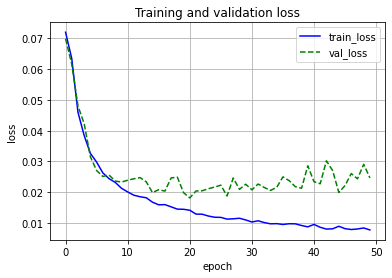

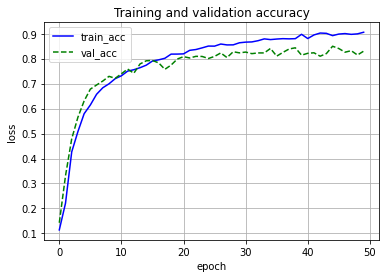

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color = 'blue', linestyle = '-', label = 'train_loss')
plt.plot(range(num_epochs), val_loss_list, color = 'green', linestyle = '--', label = 'val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color = 'blue', linestyle = '-', label = 'train_acc')
plt.plot(range(num_epochs), val_acc_list, color = 'green', linestyle = '--', label = 'val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation accuracy')
plt.grid()

